In [127]:
import torch
from torchvision import models
import torch.nn as nn
import pandas as pd
import os
import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
import time
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import lime
from lime import lime_image
import shap
import numpy as np
import seaborn as sns
from collections import deque
import random

In [51]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
# Data paths
spineData = "../data/spine"
normalPath = "../data/spine/Normal"
osteopenia = "../data/spine/Osteopenia"
Osteoporosis = "../data/spine/Osteoporosis"

In [53]:
# Dataset creation functions
def list_images(folder_path):
    extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif', '*.tiff', '*.webp')
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))
    return [os.path.abspath(img) for img in image_paths]

def assignCategory(df, images, category):
    for image in images:
        new_row = pd.DataFrame([{"path": image, "category": category}])
        df = pd.concat([df, new_row], ignore_index=True)
    return df


In [54]:
# Create dataframe
df = pd.DataFrame(columns=["path", "category"])
df = assignCategory(df, list_images(normalPath), "Normal")
df = assignCategory(df, list_images(osteopenia), "Osteopenia")
df = assignCategory(df, list_images(Osteoporosis), "Osteoporosis")

In [55]:
# Dataset class
class Xray(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transforms = transform if transform is not None else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.classes = ["Normal", "Osteopenia", "Osteoporosis"]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["category"]
        if label == "Normal":
            label = torch.tensor(0, dtype=torch.long)
        elif label == "Osteopenia":
            label = torch.tensor(1, dtype=torch.long)
        elif label == "Osteoporosis":
            label = torch.tensor(2, dtype=torch.long)
        else:
            raise ValueError("Invalid label")
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        return image, label

In [56]:
# Create eval transforms with normalization
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
# Create dataset with evaluation transforms
eval_dataset = Xray(df)
#eval_dataset = Xray(df,eval_transforms)
print(f"Dataset size: {len(eval_dataset)}")

Dataset size: 136


In [58]:
# Define the MobileNet model with dropout
def get_mobilenet_with_dropout(dropout_rate=0.0, num_classes=3):
    model = models.mobilenet_v2(pretrained=True)
    
    # Modify the classifier
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(num_features, num_classes)
    )
    
    return model

In [59]:
# Load the best model with the hyperparameters used for training

#best_params = {'batch_size': 8, 'dropout_rate': 0.0, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
best_params = {'batch_size': 8, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'weight_decay': 0.0001}
best_model = get_mobilenet_with_dropout(dropout_rate=best_params['dropout_rate'], num_classes=3)

/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [112]:
# Load the saved model weights

#model_path = '../checkpoints/best_mobilenet_modelv2.pth'  # Adjust path if necessary
model_path = 'tst.pth'
best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model = best_model.to(device)
print(f"Model loaded from {model_path}")

Model loaded from tst.pth


In [113]:
import torch
from torchviz import make_dot

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Perform a forward pass
output = best_model(dummy_input)

# Generate visualization and save as PNG
make_dot(output, params=dict(best_model.named_parameters())).render("mobilenet_architecture", format="png")


'mobilenet_architecture.png'

In [114]:
from torchview import draw_graph
import torch

# Create a dummy input tensor (batch size 1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Generate model architecture visualization
model_graph = draw_graph(best_model, input_data=dummy_input, device=device, expand_nested=True)

# Save as an image
model_graph.visual_graph.render("../output/rl/mobilenet_architecture", format="jpg")
model_graph.visual_graph.render("../output/rl/mobilenet_architecture", format="svg")



'../output/rl/mobilenet_architecture.svg'

In [115]:
from torchinfo import summary

summary(best_model, input_size=(1, 3, 224, 224), depth=3)


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 3]                    --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         896
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           5,136
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [116]:
# Create a test loader
test_loader = DataLoader(eval_dataset, batch_size=best_params['batch_size'], shuffle=False)

In [117]:
# Evaluate the model
all_preds = []
all_labels = []
all_probs = []
all_image_paths = []

In [118]:
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
        
        # Get image paths for this batch
        start_idx = batch_idx * best_params['batch_size']
        end_idx = min(start_idx + best_params['batch_size'], len(eval_dataset))
        batch_paths = [eval_dataset.df.iloc[i]["path"] for i in range(start_idx, end_idx)]
        all_image_paths.extend(batch_paths)

In [119]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

In [120]:
# Print the evaluation metrics
print("\n===== Model Evaluation Results =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


===== Model Evaluation Results =====
Accuracy: 0.8088
Precision: 0.8321
Recall: 0.7897
F1 Score: 0.8051


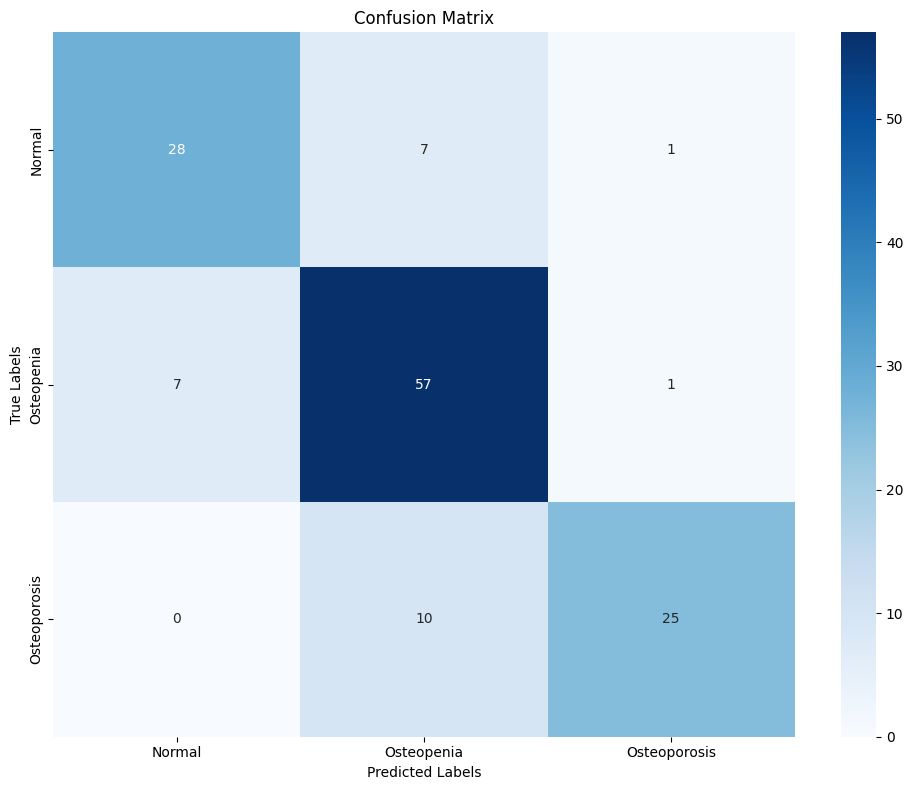

In [121]:
# Generate and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=eval_dataset.classes, 
            yticklabels=eval_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../output/rl/confusion_matrix.jpg', bbox_inches='tight')
plt.savefig('../output/rl/confusion_matrix.svg', bbox_inches='tight')
plt.show()

/tmp/ipykernel_308821/2311172720.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


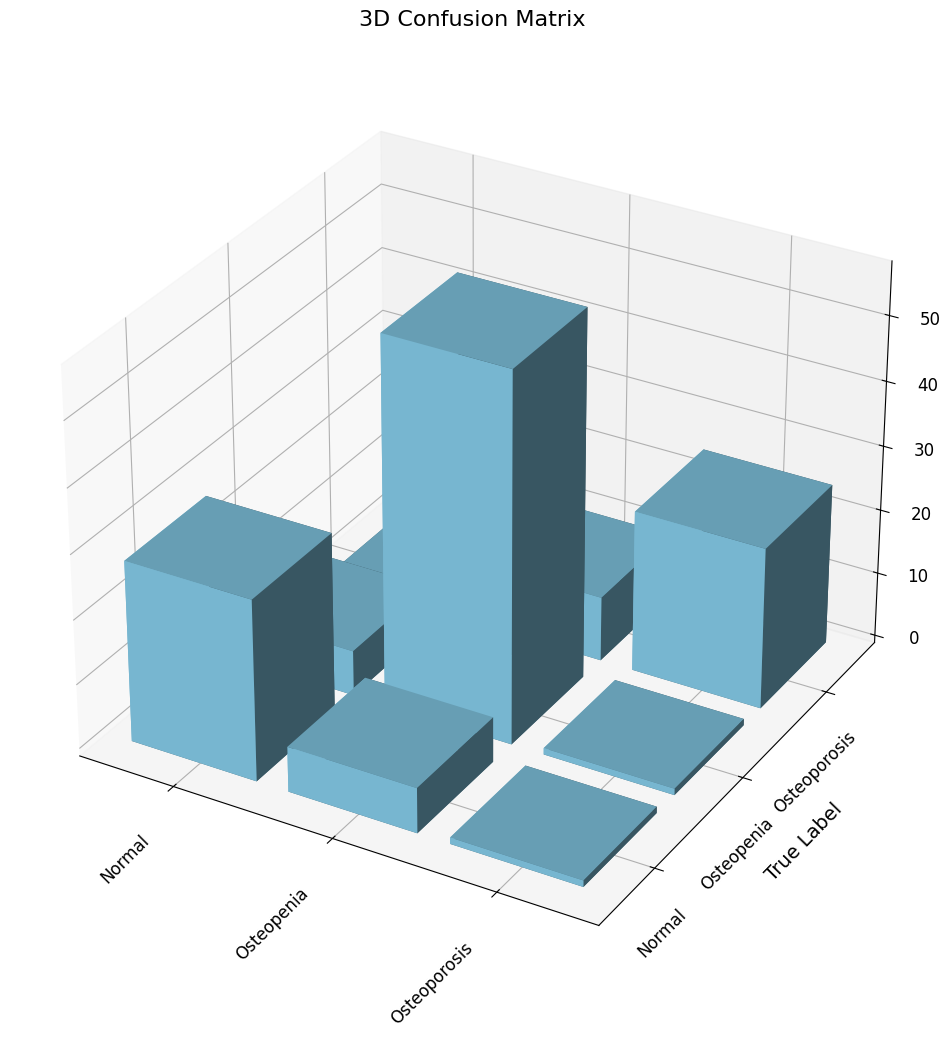

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create 3D confusion matrix visualization
fig = plt.figure(figsize=(14, 12))  # Larger figure size
ax = fig.add_subplot(111, projection='3d')

classes = eval_dataset.classes
x_data, y_data = np.meshgrid(np.arange(len(classes)), np.arange(len(classes)))
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = cm.flatten()  # Flatten confusion matrix values

# Create bars with height proportional to confusion matrix values
dx = dy = 0.8
dz = z_data
ax.bar3d(x_data, y_data, np.zeros_like(z_data), dx, dy, dz, color='skyblue', shade=True)

# Set labels and adjust text positions
ax.set_xticks(np.arange(len(classes)) + dx/2)
ax.set_yticks(np.arange(len(classes)) + dy/2)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(classes, rotation=45, ha='right', fontsize=12)


ax.set_ylabel('True Label', labelpad=20, fontsize=14)
ax.set_zlabel('Count', labelpad=15, fontsize=14)
ax.set_title('3D Confusion Matrix', fontsize=16, pad=25)

# Adjust tick label padding
ax.tick_params(axis='x', labelsize=12, pad=15)
ax.tick_params(axis='y', labelsize=12, pad=15)
ax.tick_params(axis='z', labelsize=12, pad=10)

plt.tight_layout()

# Save as both .svg and .jpg
plt.savefig('../output/rl/3d_confusion_matrix.svg', bbox_inches='tight')
plt.savefig('../output/rl/3d_confusion_matrix.jpg', bbox_inches='tight')

plt.show()


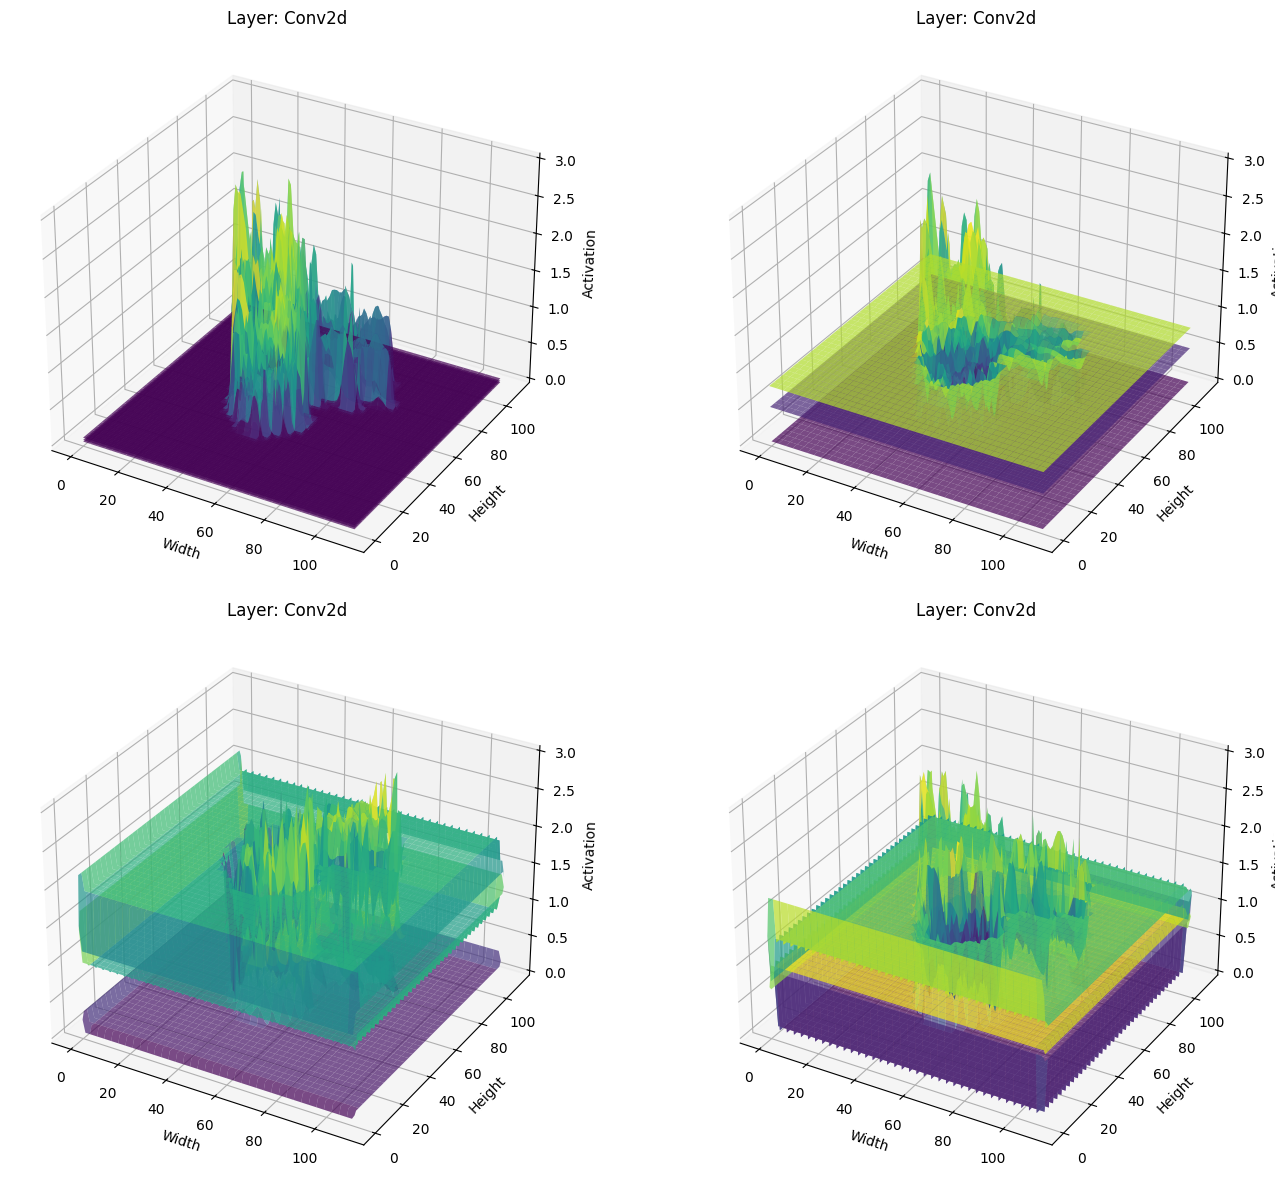

In [123]:
def visualize_feature_maps_3d(model, image):
    # Ensure image is in the right format (add batch dimension if needed)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    # Move to device
    image = image.to(device)
    
    # Create a dictionary to store activations
    activations = {}
    
    # Hook function to capture activations
    def hook_fn(module, input, output):
        activations[module] = output.detach().cpu()
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Forward pass
    with torch.no_grad():
        _ = model(image)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Visualize some feature maps in 3D
    fig = plt.figure(figsize=(15, 12))
    
    for i, (layer, activation) in enumerate(list(activations.items())[:4]):  # Show first 4 layers
        # Get feature map
        feature_map = activation[0].numpy()  # Get first batch item
        
        # Create 3D subplot
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        
        # Take a few channels to visualize (e.g., first 3)
        channels_to_show = min(3, feature_map.shape[0])
        
        for c in range(channels_to_show):
            # Normalize feature map to 0-1 range for better visualization
            feat = feature_map[c]
            feat = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)
            
            # Get dimensions
            h, w = feat.shape
            x, y = np.meshgrid(range(w), range(h))
            
            # Plot surface with color based on activation value
            surf = ax.plot_surface(x, y, feat * (c+1), cmap=plt.cm.viridis, 
                                   alpha=0.7, linewidth=0, antialiased=True)
        
        ax.set_title(f"Layer: {type(layer).__name__}")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('Activation')
    
    plt.tight_layout()
    plt.savefig('3d_feature_maps.png')
    plt.show()

# Use this function with a sample image
sample_images, _ = next(iter(test_loader))
sample_image = sample_images[0]  # Get the first image from batch
visualize_feature_maps_3d(best_model, sample_image)

In [124]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_feature_maps_3d(model, image):
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension

    image = image.to(device)

    # Dictionary to store activations
    activations = {}

    # Hook function to capture activations
    def hook_fn(module, input, output):
        activations[module] = output.detach().cpu()

    # Register hooks for convolutional layers
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        _ = model(image)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Iterate over first 4 convolutional layers
    for i, (layer, activation) in enumerate(list(activations.items())[:4]):  
        feature_map = activation[0].numpy()  # First batch item

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        channels_to_show = min(3, feature_map.shape[0])

        for c in range(channels_to_show):
            feat = feature_map[c]
            feat = (feat - feat.min()) / (feat.max() - feat.min() + 1e-8)  # Normalize

            h, w = feat.shape
            x, y = np.meshgrid(range(w), range(h))

            ax.plot_surface(x, y, feat * (c + 1), cmap=plt.cm.viridis, alpha=0.7, linewidth=0, antialiased=True)

        ax.set_title(f"Layer {i+1}: {layer.__class__.__name__}")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('Activation')

        # Save as .svg and .jpg with tight layout
        plt.savefig(f'../output/rl/3d_feature_map_{i+1}.svg', bbox_inches='tight')
        plt.savefig(f'../output/rl/3d_feature_map_{i+1}.jpg', bbox_inches='tight')

        plt.close(fig)  # Close figure to free memory

    print("Feature maps saved as 3d_feature_map_1.svg, 3d_feature_map_1.jpg, etc.")

# Use function with a sample image
sample_images, _ = next(iter(test_loader))
sample_image = sample_images[0]  
visualize_feature_maps_3d(best_model, sample_image)


Feature maps saved as 3d_feature_map_1.svg, 3d_feature_map_1.jpg, etc.


In [125]:
# Print classification report
print("\n===== Classification Report =====")
report = classification_report(all_labels, all_preds, target_names=eval_dataset.classes)
print(report)


===== Classification Report =====
              precision    recall  f1-score   support

      Normal       0.80      0.78      0.79        36
  Osteopenia       0.77      0.88      0.82        65
Osteoporosis       0.93      0.71      0.81        35

    accuracy                           0.81       136
   macro avg       0.83      0.79      0.81       136
weighted avg       0.82      0.81      0.81       136




===== Classification Report =====
              precision    recall  f1-score     support
Normal         0.800000  0.777778  0.788732   36.000000
Osteopenia     0.770270  0.876923  0.820144   65.000000
Osteoporosis   0.925926  0.714286  0.806452   35.000000
accuracy       0.808824  0.808824  0.808824    0.808824
macro avg      0.832065  0.789662  0.805109  136.000000
weighted avg   0.818198  0.808824  0.808305  136.000000


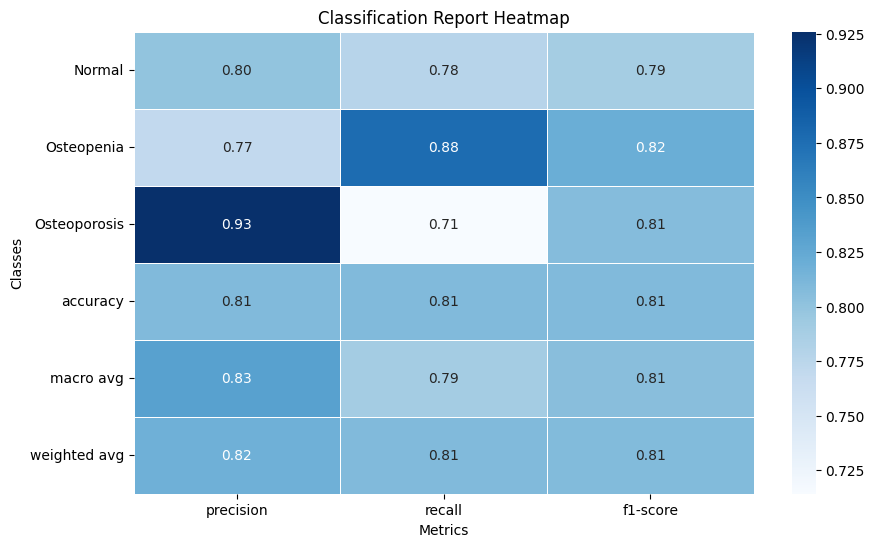

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report
report_dict = classification_report(all_labels, all_preds, target_names=eval_dataset.classes, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).T

# Print the classification report
print("\n===== Classification Report =====")
print(report_df)

# Drop support column (optional)
report_df = report_df.drop(columns=["support"], errors="ignore")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Formatting
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")

# Save and Show
plt.savefig("../output/rl/classification_report_heatmap.jpg", bbox_inches="tight")
plt.savefig("../output/rl/classification_report_heatmap.svg", bbox_inches="tight")
plt.show()


In [82]:
# Calculate per-class accuracy
class_correct = [0] * 3
class_total = [0] * 3

for i in range(len(all_preds)):
    label = all_labels[i]
    pred = all_preds[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

print("\n===== Per-Class Accuracy =====")
for i in range(3):
    class_acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{eval_dataset.classes[i]}: {class_acc:.4f} ({class_correct[i]}/{class_total[i]})")


===== Per-Class Accuracy =====
Normal: 0.7778 (28/36)
Osteopenia: 0.8769 (57/65)
Osteoporosis: 0.7143 (25/35)


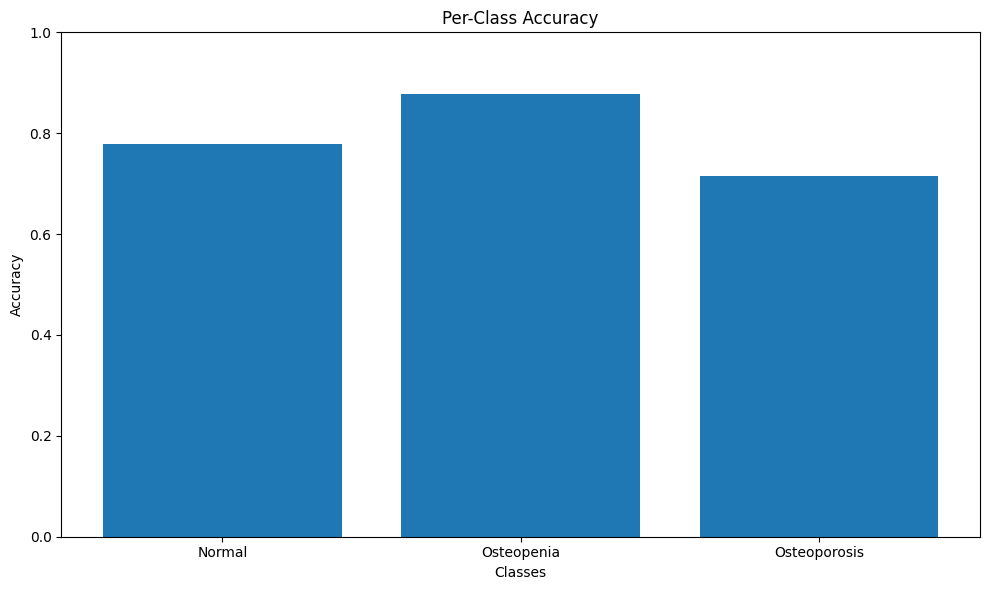

In [ ]:
# Plot per-class accuracy
class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(3)]
plt.figure(figsize=(10, 6))
plt.bar(eval_dataset.classes, class_accuracies)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../output/rl/per_class_accuracy.jpg',bbox_inches='tight')
plt.savefig('../output/rl/per_class_accuracy.svg',bbox_inches='tight')
plt.show()

In [84]:
# Create dataframe with predictions
results_df = pd.DataFrame({
    'image_path': all_image_paths,
    'true_label': [eval_dataset.classes[i] for i in all_labels],
    'predicted_label': [eval_dataset.classes[i] for i in all_preds],
    'correct': [1 if pred == label else 0 for pred, label in zip(all_preds, all_labels)]
})

In [85]:
# Save results
results_df.to_csv('prediction_results.csv', index=False)

In [95]:
# Find misclassified examples
classified = results_df[results_df['correct'] == 1].copy()
classified['confidence'] = [all_probs[i][all_preds[i]] for i in classified.index]
classified = classified.sort_values('confidence', ascending=False)

In [96]:
print(f"\n===== Misclassified Examples ({len(classified)}) =====")
print(classified.head(10))


===== Misclassified Examples (110) =====
                                            image_path    true_label  \
82   /home/narasima/Projects/Frands/vanitha/data/sp...    Osteopenia   
105  /home/narasima/Projects/Frands/vanitha/data/sp...  Osteoporosis   
3    /home/narasima/Projects/Frands/vanitha/data/sp...        Normal   
8    /home/narasima/Projects/Frands/vanitha/data/sp...        Normal   
39   /home/narasima/Projects/Frands/vanitha/data/sp...    Osteopenia   
22   /home/narasima/Projects/Frands/vanitha/data/sp...        Normal   
92   /home/narasima/Projects/Frands/vanitha/data/sp...    Osteopenia   
33   /home/narasima/Projects/Frands/vanitha/data/sp...        Normal   
70   /home/narasima/Projects/Frands/vanitha/data/sp...    Osteopenia   
115  /home/narasima/Projects/Frands/vanitha/data/sp...  Osteoporosis   

    predicted_label  correct  confidence  
82       Osteopenia        1    0.968795  
105    Osteoporosis        1    0.949351  
3            Normal        1    0.94

In [97]:
# Visualize some misclassified examples
plt.figure(figsize=(15, 12))
num_examples = min(5, len(classified))

<Figure size 1500x1200 with 0 Axes>

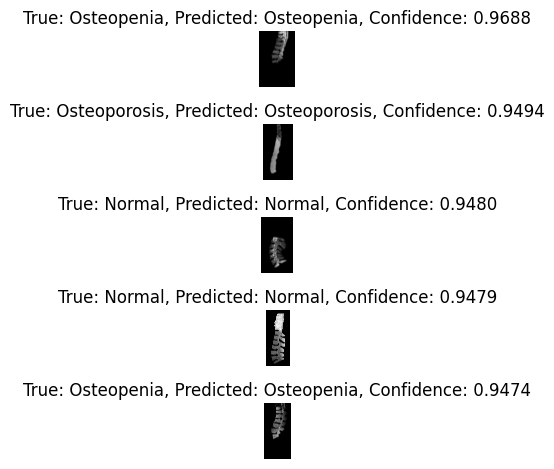

In [98]:
for i in range(num_examples):
    img_path = classified.iloc[i]['image_path']
    true_label = classified.iloc[i]['true_label']
    pred_label = classified.iloc[i]['predicted_label']
    confidence = classified.iloc[i]['confidence']
    
    # Load and display the image
    img = Image.open(img_path).convert('RGB')
    
    plt.subplot(num_examples, 1, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('correctly_classified_examples.jpg',bbox_inches='tight')
plt.savefig('correctly_classified_examples.svg',bbox_inches='tight')
plt.show()

In [90]:
# Calculate prediction time
start_time = time.time()
with torch.no_grad():
    for i in range(10):  # Run 10 times to get an average
        for images, _ in test_loader:
            images = images.to(device)
            _ = best_model(images)
end_time = time.time()
avg_time = (end_time - start_time) / 10
print(f"\nAverage inference time for entire dataset: {avg_time:.4f} seconds")
print(f"Average inference time per sample: {avg_time / len(eval_dataset):.4f} seconds")



Average inference time for entire dataset: 2.5885 seconds
Average inference time per sample: 0.0190 seconds


In [91]:
# Save model performance metrics
performance_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})
performance_df.to_csv('model_performance_metrics.csv', index=False)

print("\nEvaluation complete! Results saved to CSV files.")


Evaluation complete! Results saved to CSV files.
